In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from diffusers import DDIMScheduler, StableDiffusionPipeline
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot

model_id = "CompVis/stable-diffusion-v1-4"
device = 'cuda'

print(f"Loading model {model_id} via StableDiffusionPipeline...")
try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
except ImportError:
    print("LocalStableDiffusionPipeline not found, using standard.")
    LocalStableDiffusionPipeline = StableDiffusionPipeline

pipeline = LocalStableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.set_progress_bar_config(disable=True)

def load_prompts(file_path):
    with open(file_path, 'r') as f:
        prompts = [line.strip() for line in f.readlines()]
    return prompts

/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for

Loading model CompVis/stable-diffusion-v1-4 via StableDiffusionPipeline...


/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
base_path = "/home/gpuadmin/cssin/cond_Jacobian"

mem_prompts_path = os.path.join(base_path, "prompts/sd1_mem.txt")
nmem_prompts_path = os.path.join(base_path, "prompts/sd1_nmem.txt")

mem_prompts = load_prompts(mem_prompts_path)
nmem_prompts = load_prompts(nmem_prompts_path)

In [4]:
with torch.inference_mode():
    prompt_embeds_memorized = pipeline._encode_prompt(mem_prompts, device, 1, False, None)
    prompt_embeds_nmemorized = pipeline._encode_prompt(nmem_prompts, device, 1, False, None)

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

In [5]:
prompt_embeds = torch.cat([prompt_embeds_memorized, prompt_embeds_nmemorized], dim = 0).view(1000, -1).cpu()

In [6]:
labels_array = np.array(['memorized'] * 500 + ['non-memorized'] * 500)

In [10]:
maps = []

for n in (1.5, 5, 10, 20, 50, 100, 200):
    reducer = umap.UMAP(
        n_neighbors=n,
        min_dist=0.1
    )
    mapper_reduce = reducer.fit(prompt_embeds)
    maps.append(mapper_reduce)

ValueError: n_neighbors must be greater than 1

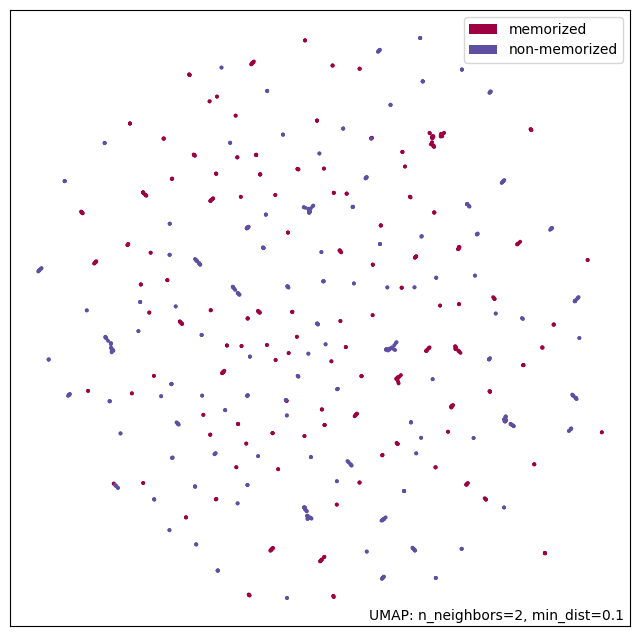

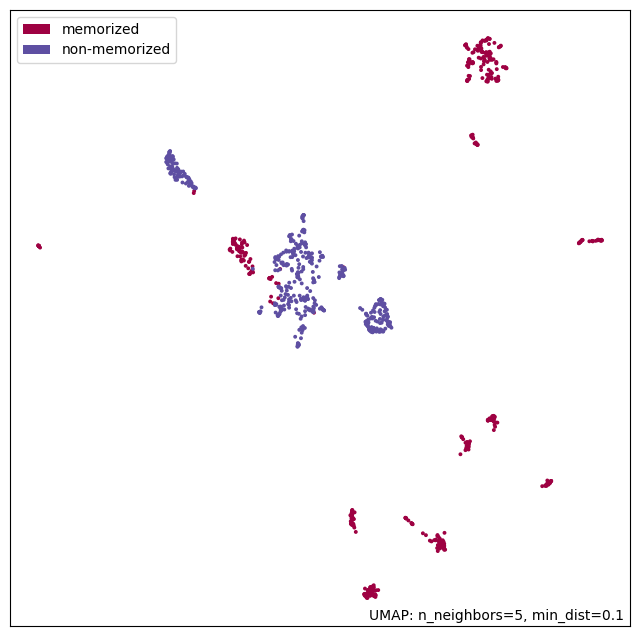

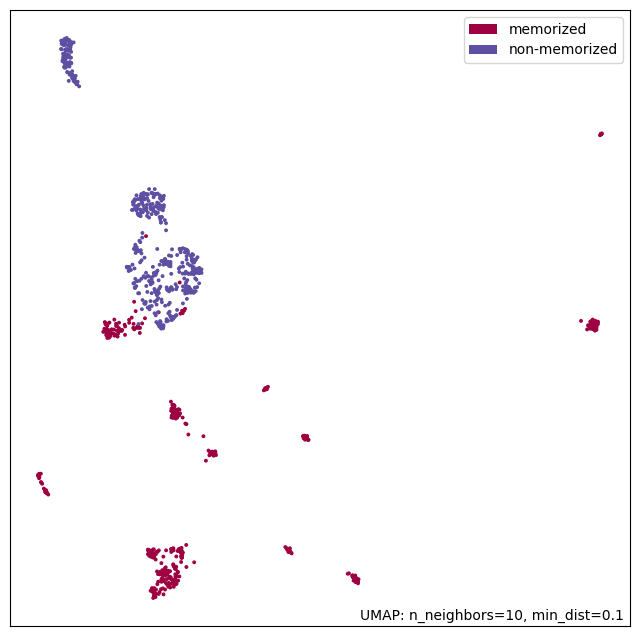

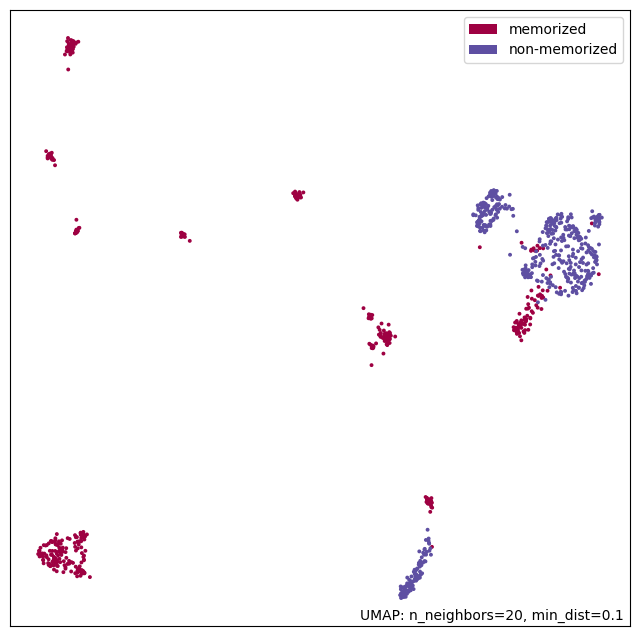

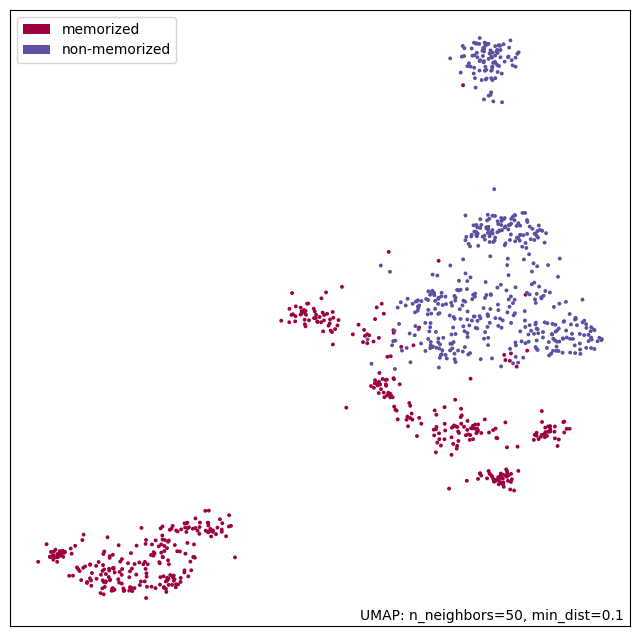

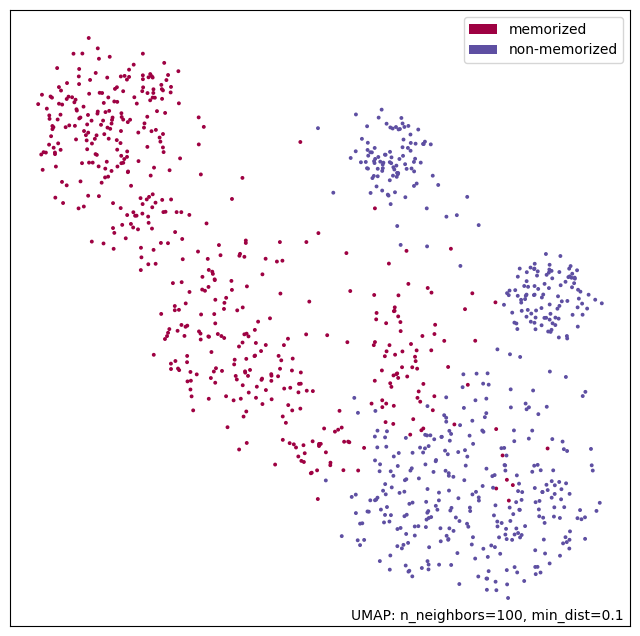

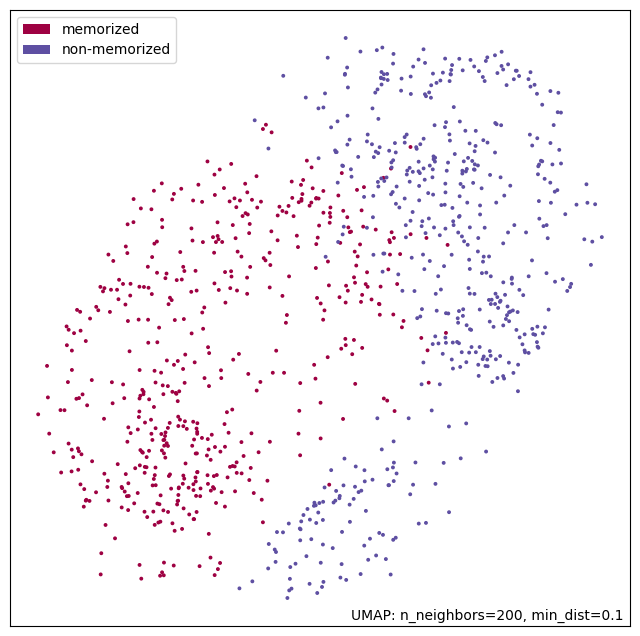

In [9]:
for mapper in maps:
    umap.plot.points(mapper, labels=labels_array)

/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


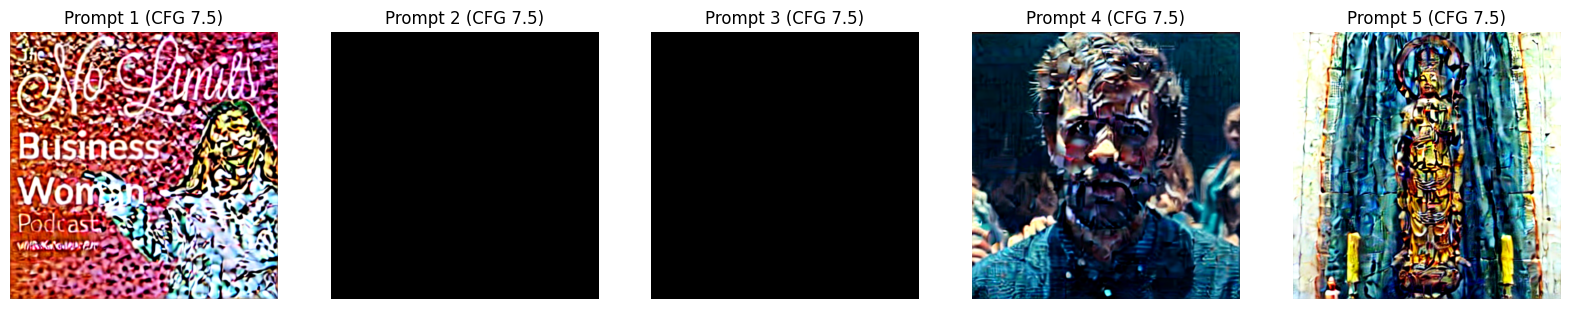

In [44]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import os
# 1. 모델 설정 (이미 로드되어 있다면 생략 가능)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32).to(device)
# 2. 프롬프트 로드
base_path = "/home/gpuadmin/cssin/cond_Jacobian"
mem_prompts_path = os.path.join(base_path, "prompts/sd1_mem.txt")
with open(mem_prompts_path, 'r') as f:
    mem_prompts = [line.strip() for line in f.readlines()]
# 테스트할 배치 사이즈 설정
batch_size = 5
batch_prompts = mem_prompts[:batch_size]
# 3. 임베딩 추출
# Positive Embeddings (Conditional)
prompt_embeds = pipeline._encode_prompt(batch_prompts, device, 1, False, None)
# Negative Embeddings (Unconditional) - CFG를 위해 필요
negative_prompts = [""] * batch_size
negative_prompt_embeds = pipeline._encode_prompt(negative_prompts, device, 1, False, None)
# 4. 이미지 생성 (CFG 적용)
generator = torch.Generator(device).manual_seed(42)
guidance_scale = 7.5  # CFG Scale 설정
images = pipeline(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    guidance_scale=guidance_scale,
    generator=generator
).images
# 5. 결과 시각화
fig, axes = plt.subplots(1, batch_size, figsize=(20, 4))
for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Prompt {i+1} (CFG {guidance_scale})")
plt.show()